# IsoMut example run

### Accurate mutation detection in whole genome sequences of multiple isogenic samples with IsoMut

##### O. Pipek, D. Ribli, J. Molnár, Á. Póti, M. Krzystanek, A. Bodor, G. E. Tusnády, Z. Szallasi, I. Csabai, and D. Szüts



---

## Overview:

- The ipython notebook below contains everything (including the download and indexing of data BAM files and the reference fasta file) to run IsoMut on some of the samples described in the article. After slight modifications to input and output directories, it can be run on any data, whenever multiple isogenic samples are available.

- The dataset used below is a reduced version of the one used in the article and is available online at the website [genomics.hu](http://www.genomics.hu/tools/isomut/IsoMut_example_dataset.tar.gz). The BAM files of 10 samples contain only a 10 MB length portion of the first chromosome of the genome, allowing for a rapid analysis for testing purposes. Also, the Gallus gallus reference genome in fasta format can be downloaded from [ensembl.org](ftp://ftp.ensembl.org/pub/release-84/fasta/gallus_gallus/dna/). 

- Besides identifying unique mutations with predefined filters, this notebook also demonstrates the tuning of the mutation quality score (score), when control samples are available. In these samples no unique, treatment-induced mutations should be present, thus the score can be tuned by minimizing the number of detected mutations in these samples, while maintaining satisfyingly high numbers in samples that underwent strong mutagenic treatments. The tuning procedure can be individually carried out for SNVs, insertions and deletions, achieving optimized results for all types of mutations.

- The value of the score is related to the probability of correctly categorizing a candidate mutation as a true positive. More precisely, the probability *p* of incorrectly detecting a difference in the genotypes of the two noisiest samples in the given position can be calculated by Fisher’s exact test on the two samples. This gives the probability of being wrong to state that the reads found in the two noisiest samples are from different nucleotide distributions. The score is calculated as the negative logarithm of *p*. Thus a higher score value gives a ‘surer’ mutation.

- The notebook contains shell and python commands combined.



<span class="label label-warning">Note</span> The score optimisation for insertions and deletions are skipped in the notebook below, due to the lack of sufficiently high numbers of indels in the dataset. However, the commands are included in the notebook and can be run readily on any data very similarly to the score optimisation process for SNVs.

<span class="label label-danger">Warning</span> We strongly advise against the biological interpretation of the data below. As IsoMut was run on 10 samples only and on a very short portion of the whole genome, any conclusions drawn from the results are unreliable. The notebook below serves demonstration purposes only.


## Steps:

- 1) Obtain and prepare data BAM files: download from [genomics.hu](http://www.genomics.hu/tools/isomut/IsoMut_example_dataset.tar.gz), unzip, index
- 2) Obtain and prepare the reference genome: download from [ensembl.org](ftp://ftp.ensembl.org/pub/release-84/fasta/gallus_gallus/dna/), unzip, index
- 3) Obtain and prepare the IsoMut tool: download from [github](https://github.com/genomicshu/isomut), compile
- (4) Modify example script if necessarry)
- 5) Run the script
- 6) Analyze results, optimise score value

---

## Preparations (steps 1, 2 and 3)

#### Importing necessarry python modules

In [1]:
import pandas as pd
import numpy as np
import os
import subprocess

import matplotlib.pyplot as plt
%matplotlib inline

#### 1) Downloading, unzipping, indexing of BAM files

In [2]:
%%bash

wget -q http://www.genomics.hu/tools/isomut/IsoMut_example_dataset.tar.gz
tar -zxf IsoMut_example_dataset.tar.gz
for file in IsoMut_example_dataset/*
do
    gunzip $file
done
for file in IsoMut_example_dataset/*
do
    samtools index $file
done

#### 2) Downloading, unzipping, indexing of reference fasta file

In [3]:
%%bash

mkdir chrom1_ref_fasta
cd chrom1_ref_fasta
wget -q ftp://ftp.ensembl.org/pub/release-84/fasta/gallus_gallus/dna/Gallus_gallus.Galgal4.dna.chromosome.1.fa.gz
gunzip Gallus_gallus.Galgal4.dna.chromosome.1.fa.gz
samtools faidx Gallus_gallus.Galgal4.dna.chromosome.1.fa
cd ..

#### 3) Downloading and compiling IsoMut

In [4]:
%%bash 

########################################
# Download from git
git clone https://github.com/genomicshu/isomut.git
cd isomut/src

# compile
gcc -c -O3 isomut_lib.c fisher.c  -W -Wall
gcc -O3 -o isomut isomut.c isomut_lib.o  fisher.o -lm -W -Wall

cd ../..

Cloning into 'isomut'...


In [5]:
import os
os.chdir('isomut/')
os.mkdir('output')

## Viewing (and modifying) example script (step 4)

In [6]:
%%writefile isomut_example_script.py
#!/usr/bin/env python

#################################################
# importing the wrapper
#################################################
import sys,os
#add path for isomut_wrappers.py
#	if not running it from the isomut directory
#	change os.getcwd for the path to it
sys.path.append(os.getcwd()+'/src')
#load the parallel wrapper function
from isomut_wrappers import run_isomut

#add path for isomut, if its in the path comment/delete this line
#	if not running it from the isomut directory
#	change os.getcwd for the path to it
os.environ["PATH"] += os.pathsep + os.getcwd() +'/src'


#################################################
# defining administrative parameters
#################################################
#using parameter dictionary, beacause there are awful lot of parameters
params=dict()
#minimum number of blocks to run
# usually there will be 10-20 more blocks
params['n_min_block']=100
#number of concurrent processes to run
params['n_conc_blocks']=4
#genome
params['ref_fasta']="/".join(os.getcwd().split("/")[:-1])+'/chrom1_ref_fasta/Gallus_gallus.Galgal4.dna.chromosome.1.fa'
#input dir output dir
params['input_dir']="/".join(os.getcwd().split("/")[:-1])+'/IsoMut_example_dataset/'
params['output_dir']='output/'
#the bam files used
samples=['S07','S09','S12','S13','S15','S22','S24','S27','S28','S30']
params['bam_filenames']=[sample+'_reduced.bam' for sample in samples ]
#limit chromosomes (for references with many scaffolds)
# just comment/delete this line if you want to analyze all contigs in the ref genome
#params['chromosomes']=map(str,range(1,29))+ ['32','W','Z','MT']
params['chromosomes']=['1']

#################################################
# defining mutation calling parameters
#    default values here ...
#################################################
params['min_sample_freq']=0.21
params['min_other_ref_freq']=0.93
params['cov_limit']=5
params['base_quality_limit']=30
params['min_gap_dist_snv']=0
params['min_gap_dist_indel']=20

#################################################
# and finally run it
#################################################
run_isomut(params)

Overwriting isomut_example_script.py


## Running IsoMut (step 5)

In [7]:
%%bash

chmod +x isomut_example_script.py
./isomut_example_script.py

Defining parallel blocks ...
Done

blocks to run: 101
running: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 
Done

Preparing for second round...
Defining parallel blocks ...
Done

blocks to run: 101
running: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 
Done

Finalizing output...
Cleaning up...

Done


## Analyzing results (step 6)

#### Collecting results into one file

In [8]:
%%bash

head -n1 output/all_SNVs.isomut    > all_output.csv
cat output/all_SNVs.isomut | grep -v sample >> all_output.csv
cat output/all_indels.isomut | grep -v sample >> all_output.csv

#### Loading data

In [9]:
output=pd.read_csv('all_output.csv',sep='\t',header=0)

### Plotting the number of mutations found in each sample for different score thresholds

In [10]:
##define sample groups
samples=['S07','S09','S12','S13','S15','S22','S24','S27','S28','S30']
control_idx=[2,4]+ [7,9]
weak_idx=[0,5]
strong_idx=[1,3,6,8]

def plot_tuning_curve(output,ymax):
    #set cols
    cols=['lightgreen' for i in xrange(10)]
    for i in control_idx:
        cols[i]='dodgerblue' 
    for i in weak_idx:
        cols[i]='salmon' 

    fig,ax=plt.subplots()
    fig.set_size_inches(12,9)
    for i,col in zip(range(10),cols):
        score=output[(output['#sample_name']==samples[i]+'_reduced.bam')].sort(['score'])['score']
        ax.plot(score,len(score)-np.arange(len(score)),c=col,lw=4,label='')
    ax.set_xlabel(r'score threshold',fontsize=16)
    ax.set_ylabel(r'Mutations found',fontsize=16)
    ax.set_ylim(1,ymax)
    ax.set_xlim(0,4)
    ax.grid()
    dump=ax.legend(loc='upper right',fancybox='true',fontsize=16)


    fig,ax=plt.subplots()
    fig.set_size_inches(12,9)
    for i,col in zip(range(30),cols):
        score=output[(output['#sample_name']==samples[i]+'_reduced.bam')].sort(['score'])['score']
        ax.plot(score,len(score)-np.arange(len(score)),c=col,lw=4,label='')

    ax.set_xlabel(r'score threshold',fontsize=16)
    ax.set_ylabel(r'Mutations found',fontsize=16)
    ax.set_ylim(1,ymax)
    ax.set_xlim(0,4)
    ax.set_yscale('log')
    ax.grid()
    #dump=ax.legend(loc='upper right',fancybox='true',fontsize=16)

#### Plotting SNV counts

- It can be seen that by setting the score threshold to ~ 2 there are no mutations in the control samples, while the treated samples still have reasonably high numbers of them.

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:476: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


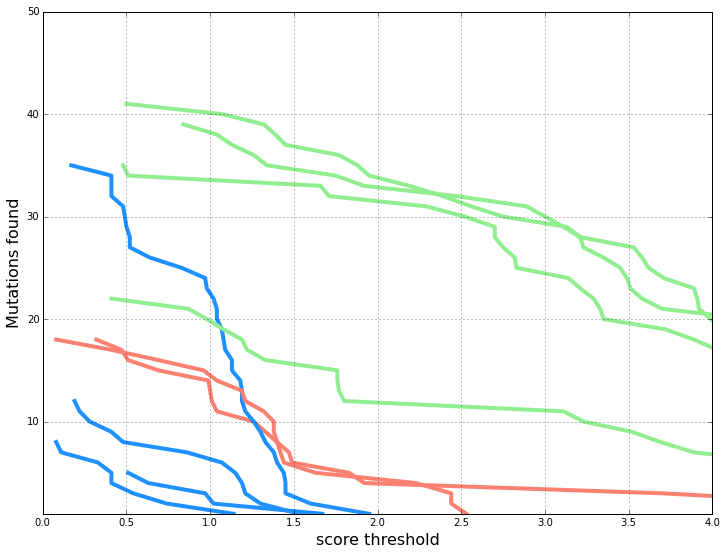

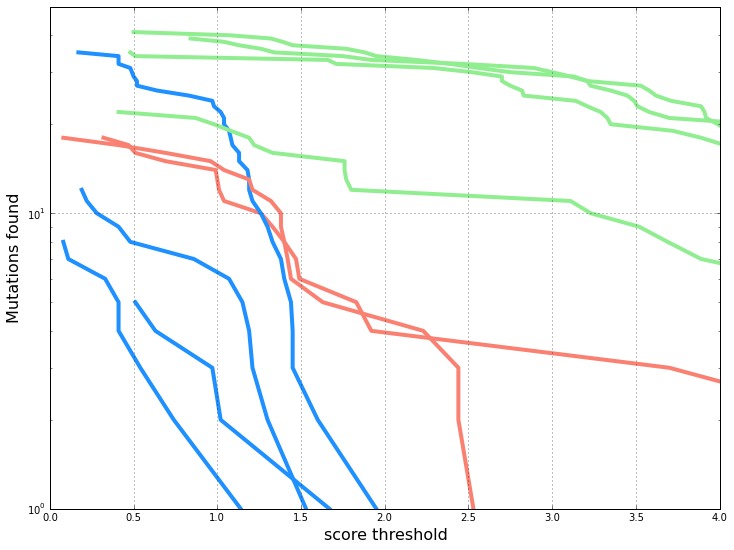

In [11]:
plot_tuning_curve(output[output['type']=='SNV'],50)

#### Plotting insertion and deletion counts

- The above plotting function can be readily applied in the case of indels as well, using the parameters below. However, as the investigated portion of the genome contains very few indels, no further insight can be gained by optimizing the score value. In general, for real datasets, the above practise is applicable for all types of detected mutations.

In [16]:
plot_tuning_curve(output[output['type']=='INS'],30)

In [17]:
plot_tuning_curve(output[output['type']=='DEL'],40)

## Plotting a quasi-ROC curve for score optimization

- False positive rate: the ratio of mutations found in control samples to the length of the genome
- For a fast and convenient optimization process, true positives were estimated as the mutations found in all treated samples. Some of these may in fact be false positives, but as the mutation rate in treated samples are higher by a factor of 100-1000 than in control samples, this estimation still gives reasonable results.
- The ROC curves below show how the change in the selected score threshold affects the number of false and true positive results. For our purposes, very low false positive rates were necessary, thus we chose fairly strict filtering values to achieve this.


In [12]:
def plot_roc(output,score0,score_sel):

    fig,ax=plt.subplots()
    fig.set_size_inches(12,9)
    fp, tp = [0  for i in xrange(100) ],[0  for i in xrange(100) ]
    for score_lim,j in zip(np.linspace(score0,10,100),range(100)):
        muts=[]
        for i in xrange(10):
            filt_idx =  output['#sample_name'] ==  samples[i]+'_reduced.bam'
            filt_idx = filt_idx & ((output['score']>score_lim))
            muts.append(len(output[filt_idx]))
        muts=np.array(muts)
        fp[j] ,tp[j]=1e-3*np.mean(muts[control_idx]),1e-3*np.mean(muts[weak_idx+strong_idx])
    ax.step(fp,tp,c='magenta',lw=4,label='quasy ROC, scannning the tuning parameter')
     
    muts=[]
    for i in xrange(10):
        filt_idx =  output['#sample_name'] == samples[i]+'_reduced.bam'
        filt_idx = filt_idx & ((output['score']>score_sel))
        muts.append(len(output[filt_idx]))
    muts=np.array(muts)

    ax.plot(1e-3*np.mean(muts[control_idx]),1e-3*np.mean(muts[weak_idx+strong_idx]),
            'o',mec='dodgerblue',mfc='dodgerblue',ms=15,mew=3,label='selected parameter')
    ax.legend(fancybox=True,loc='lower right',fontsize=16)

    #ax.set_xlim(0,30)
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=-0.0001)
    ax.set_xlabel('false positive rate 1/Mbp ',fontsize=16)
    dump=ax.set_ylabel('mutation rate  1/Mbp ',fontsize=16)

### SNVs

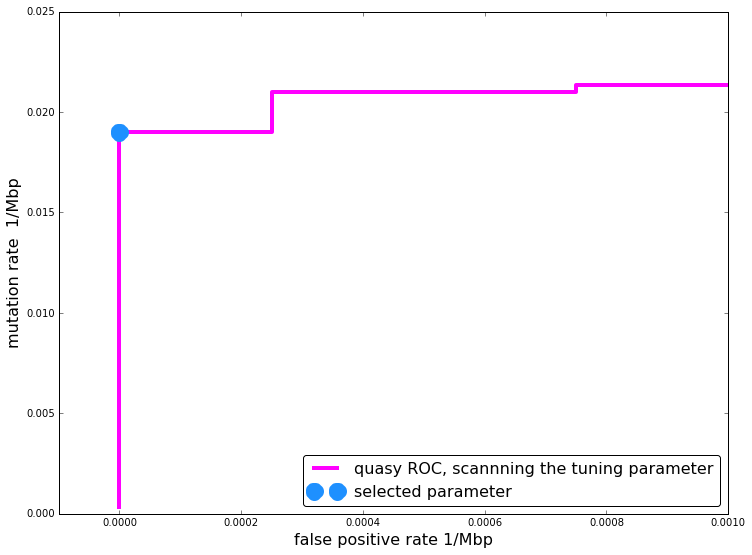

In [13]:
plot_roc(output[output['type']=='SNV'],score0=1.5,score_sel=2)

### Indels

- Please note, that the selected score thresholds for insertions and deletions are usually very different than the score threshold chosen for SNVs, because these types of mutations appear both with different mutation and different noise frequencies. The example dataset is not suitable for determining these threshold values, but in general, the same steps should be carried out as in the case of SNVs.

In [20]:
plot_roc(output[output['type']=='INS'],score0=0.5,score_sel=1)

In [21]:
plot_roc(output[output['type']=='DEL'],score0=0.5,score_sel=1.35)

---

## Plotting the final results with optimized score thresholds

---

In [14]:
#define plotting func
def plot_mutres(table):
    #group mutations per samples
    sample_counts=table.groupby(['#sample_name']).count().reset_index()[['#sample_name','mut']]
    sample_counts.columns=['sample','count']

    #add zeroes if a sample is missing
    for i in samples:
        if (not i+'_reduced.bam' in set(sample_counts['sample'])):
            sample_counts=pd.concat([sample_counts,pd.DataFrame({'sample':[i+'_reduced.bam'], 'count' : [0]})])
            sample_counts=sample_counts.sort('sample').reset_index()[['sample','count']]

    #plot
    fig,ax=plt.subplots()
    fig.set_size_inches(12,9)

    #starting clones and controls
    ax.bar(control_idx,[sample_counts.loc[i,'count'] for i in control_idx],
           facecolor='dodgerblue',edgecolor='none',label='starting clone and controls')
    #weak treatment
    ax.bar(weak_idx,[sample_counts.loc[i,'count'] for i in weak_idx],
           facecolor='salmon',edgecolor='none',label='weak mutagenic treatment')
    #strong treatment
    ax.bar(strong_idx,[sample_counts.loc[i,'count'] for i in strong_idx],
           facecolor='lightgreen',edgecolor='none',label='strong mutagenic treatment')

    #samples labels
    names=samples

    ax.set_xticks(0.4+np.arange(len(names)))
    ax.set_xticklabels(names,rotation='vertical',fontsize=14)
    #axis, and legend
    ax.set_xlabel(r'samples',fontsize=18)
    ax.set_ylabel(r'Mutations detected',fontsize=18)
    dump=ax.legend(loc='best',fancybox='true',fontsize=16)
    
    #print the table
    sample_counts['code']=names
    return sample_counts[['code','count']]

### SNVs

code  count
0  S07      4
1  S09     32
2  S12      0
3  S13     11
4  S15      0
5  S22      3
6  S24     31
7  S27      0
8  S28     33
9  S30      0

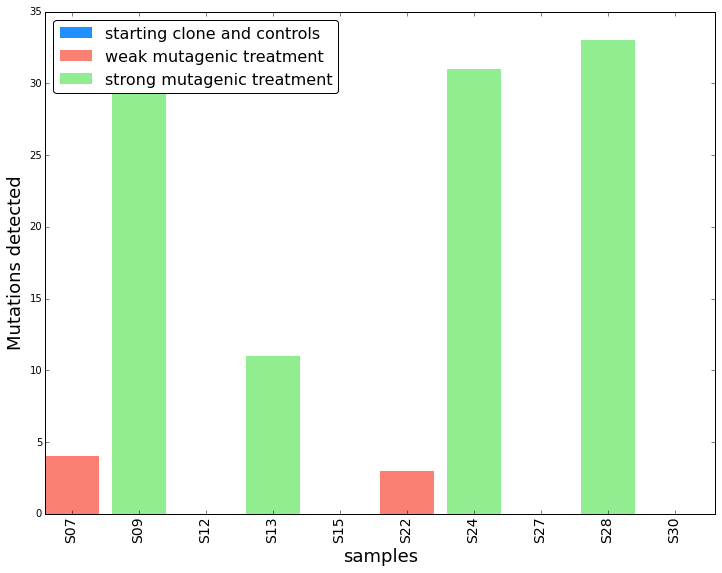

In [15]:
plot_mutres(output[(output['type']=='SNV' ) & (output['score']> 2)] )

### Insertions and deletions

In [24]:
plot_mutres(output[(output['type']=='INS' ) & (output['score']> 1)] )

In [25]:
plot_mutres(output[(output['type']=='DEL' ) & (output['score']> 1.35)] )